# Calcium Group Plotting & Statistics

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
import lvm_read
from tkinter import Tk
from tkinter.filedialog import askdirectory
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import glob
import fnmatch

plt.style.use('seaborn-white')
%matplotlib inline

py.offline.init_notebook_mode(connected=True)

## Selecting the calcium data folder
Should contain all .mat files (can also be in subfolders)

In [2]:
# root = Tk()
# ttl = "Select directory"

# if os.name == 'nt':
#     dir1 = r'D:\MRIDATA\Calciumanalysis\GRCaMP\3Hz'   # Windows
# else:
#     dir1 = '/Volumes/Zhivaz/'
    
# root.withdraw()
# file_path = askdirectory(initialdir = dir1, title = ttl)
# root.update()
# root.destroy()
# print('main path :', file_path)

file_path = r'D:\MRIDATA\Calciumanalysis\LckGRCaMP\3Hz'

calcium_regressors = []
for folderName, subfolders, filenames in os.walk(file_path):
    for file in filenames:
        if fnmatch.fnmatch(file, '*.mat'):
            calcium_regressors.append(os.path.join(os.path.abspath(folderName),file))

# calcium_regressors = glob.glob(os.path.join(os.path.abspath(file_path),file_ending))
print('.mat files found: ',calcium_regressors)


.mat files found:  ['D:\\MRIDATA\\Calciumanalysis\\LckGRCaMP\\3Hz\\6790_E16\\6790_E16.mat', 'D:\\MRIDATA\\Calciumanalysis\\LckGRCaMP\\3Hz\\6792_E7\\6792_E7.mat', 'D:\\MRIDATA\\Calciumanalysis\\LckGRCaMP\\3Hz\\6793_E8\\6793_E8.mat']


In [3]:
alldata=[]
N_files=len(calcium_regressors)

for i in range(N_files):
    alldata.append(sio.loadmat(calcium_regressors[i]))
    
    
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 

In [4]:
# N_files
# animallist = alldata[0].keys()
# alldata[0].values()
# animallist
# alldata[0]

# name_channel = get_nth_key(alldata[0],4)

stim_events = alldata[0][os.path.split(calcium_regressors[0])[1][:-4]+' Channel 1']['stim'][0][0][0]

#Create data frames
time_sec=alldata[0][os.path.split(calcium_regressors[0])[1][:-4]+' Channel 1']['time'][0][0][0] # must be same for all files, so read it from first mat file
index = pd.Index(time_sec)
columns = pd.MultiIndex.from_product([['channel1','channel2'],['mean','SD','stim']],names=['channel','datatype'])
# df0 = pd.DataFrame(np.zeros((index.size,columns.size)),index = index, columns = columns)

dfs=[]
measurements=[]
for i in range(N_files):
    measurementname = get_nth_key(alldata[i],4)[:-10]
    df = pd.DataFrame(np.zeros((index.size,columns.size)),index = index, columns = columns)
    
    df['channel1','mean'] = alldata[i][get_nth_key(alldata[i],3)]['mean'][0][0][0][0:index.size]
    df['channel1','SD'] = alldata[i][get_nth_key(alldata[i],3)]['SD'][0][0][0][0:index.size]
    
    df['channel2','mean'] = alldata[i][get_nth_key(alldata[i],4)]['mean'][0][0][0][0:index.size]
    df['channel2','SD'] = alldata[i][get_nth_key(alldata[i],4)]['SD'][0][0][0][0:index.size]
    measurements.append(measurementname)
    dfs.append(df)

dffinal=pd.concat(dfs, axis=1, names=['channel','datatype','scan'], ignore_index=False)

# forplotting_mean=[]
# forplotting_mean.append(dffinal['channel1']['mean'].mean(axis=1))
# forplotting_mean.append(dffinal['channel2']['mean'].mean(axis=1))

forplotting_individual=[]
forplotting_individual.append(dffinal['channel1']['mean'])
forplotting_individual.append(dffinal['channel2']['mean'])


datatype
mean    0.176220
mean    0.607819
mean    0.261543
Name: std, dtype: float64
datatype
mean    0.027129
mean    0.030248
mean    0.058163
Name: std, dtype: float64


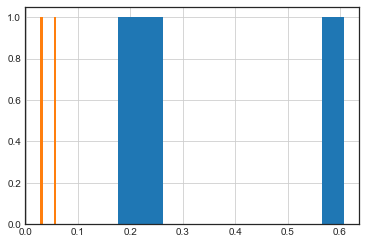

In [5]:
# Optional:  Normalize by baseline standard deviation
def normalize_by_bsl(inputdf, bsl_duration=10):
    xx = inputdf.loc[0:bsl_duration,:].describe()
#     print(xx)
#     x = xx.loc['mean',:]/xx.loc['std',:]
    x = xx.loc['std',:]
    print(x)
    x.hist()
    np.histogram(x)
    
    target=1  #<-- choose a value here
    k=0
    for i in x:
        factor = target/i
        inputdf.iloc[:,k]=inputdf.iloc[:,k]*factor
        k+=1

#     inputdf=inputdf.mean(axis=1)
    return inputdf

ch1_normalized = normalize_by_bsl(forplotting_individual[0])
ch2_normalized = normalize_by_bsl(forplotting_individual[1])
ch1_normalized.columns = ch2_normalized.columns = measurements

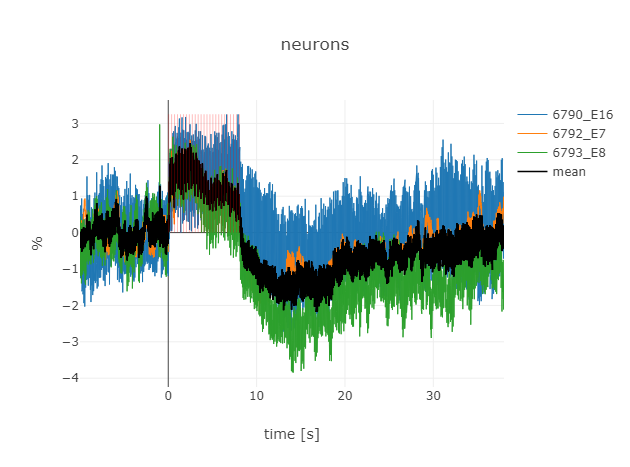

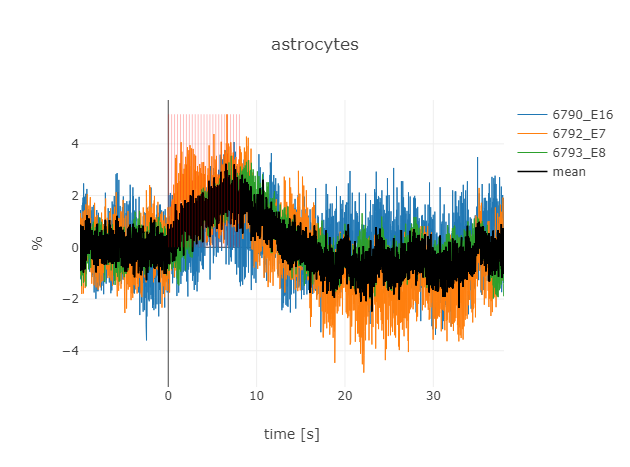

In [6]:
import importlib, plottools  # where I put the plotly code
importlib.reload(plottools)

plottools.plotlyplot(ch1_normalized, stim_events, duration=0.1, titleinput='neurons')
plottools.plotlyplot(ch2_normalized, stim_events, duration=0.1, titleinput='astrocytes')

## fMRI ROI plot

In [27]:
# groupstatsfolder = 'D:/MRIDATA/Calciumanalysis/GRCaMP/1Hz/groupstats'
# groupstatsfolder = os.path.join(r'D:\MRIDATA\Calciumanalysis\GRCaMP\3Hz\groupstats')
groupstatsfolder = os.path.join(file_path,'groupstats')

file_ending = "*ROIdataNew.1D"
ROIfiles = glob.glob(os.path.join(os.path.abspath(groupstatsfolder),file_ending))

dataframes = []
keys = []
i=0
for files in ROIfiles:
    dataframes.append(pd.read_table(files))
    name=os.path.basename(ROIfiles[i][:-len(file_ending)+1]) #cut off *ROIdata.1D = 10 chars 
    del dataframes[-1]['File']
    del dataframes[-1]['Sub-brick']
    keys.append(name + dataframes[-1].columns[0])  # adjust for number of ROIs
    keys.append(name + dataframes[-1].columns[1])
    i+=1

    
frames = pd.concat(dataframes, axis=1)
frames.columns = keys  


In [29]:
starttime = 120
Nblocks = 15
duration = 8
ISI = 90

cutoff = 10

stimList=list(range(starttime-cutoff,starttime-cutoff+Nblocks*ISI,ISI))
print(stimList)


[110, 200, 290, 380, 470, 560, 650, 740, 830, 920, 1010, 1100, 1190, 1280, 1370]


## Plotting full BOLD timecourse

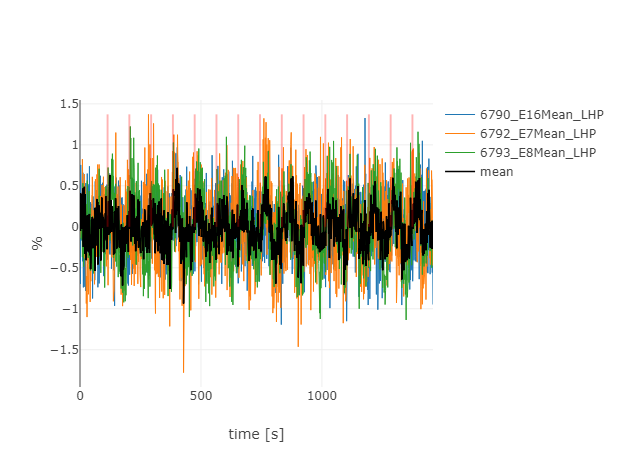

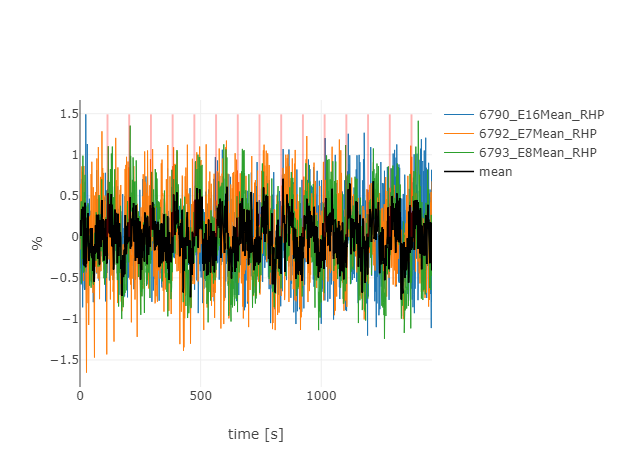

In [34]:
plot = frames.filter(regex='LHP')
plottools.plotlyplot(plot, stimList, duration=duration)
plot = frames.filter(regex='RHP')
plottools.plotlyplot(plot, stimList, duration=duration)

## Plotting averaged BOLD blocks

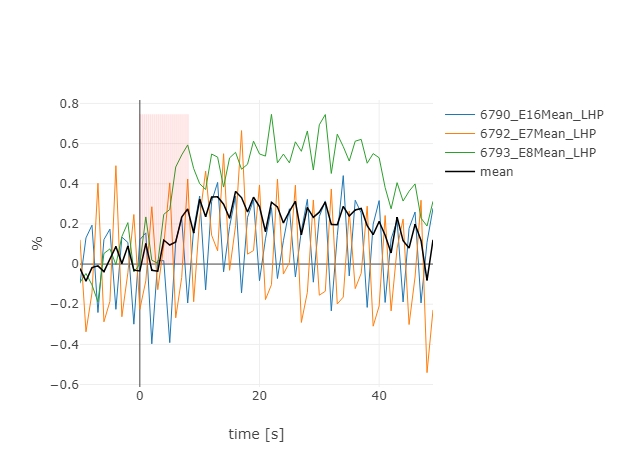

In [37]:
def averageblocks(inputdf,starttimes,baseline,duration):
    idx = pd.IndexSlice
    blocks_mean=[]
    block_time = np.arange(-baseline,duration) 
    blockIndex = pd.Index(block_time, name='Time [s]')
    
    for i in range(frames.columns.size):
        block_single = []
        
        for n in starttimes:
            #shifting the baseline of each block to zero
            _temp = inputdf.iloc[n-baseline:n+duration,i].reset_index(drop=True)
            _temp -= _temp.iloc[:baseline].mean()
            block_single.append(_temp)
        
        blocks = pd.concat(block_single, axis=1, ignore_index = True)
        blocks['time'] = blockIndex
        blocks.set_index('time',drop=True,inplace=True)           
            
        blocks_mean.append(blocks.mean(axis=1))
        
    blocks_output = pd.concat(blocks_mean, axis=1, ignore_index = True)
    blocks_output['time'] = blockIndex
    blocks_output.set_index('time',drop=True,inplace=True)
    return blocks_output
                                     
BOLDaverages = averageblocks(frames,stimList,10,50)
BOLDaverages.columns =keys


plot = BOLDaverages.filter(regex='LHP')
plottools.plotlyplot(plot, stim_events, duration=0.1)

plot = BOLDaverages.filter(regex='RHP')
plottools.plotlyplot(plot, stim_events, duration=0.1)

## Plot all together

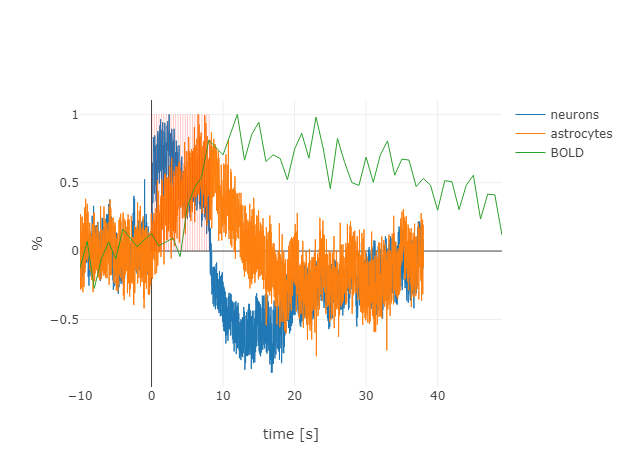

In [40]:
# importlib.reload(plottools)

allplots=[]
allplots.append(ch1_normalized.mean(axis=1))
allplots.append(ch2_normalized.mean(axis=1))
BOLDplot = BOLDaverages.filter(regex='RHP')
allplots.append(BOLDplot.mean(axis=1))

allplots[0].name = 'neurons'
allplots[1].name = 'astrocytes'
allplots[2].name = 'BOLD'


multimodalplot = pd.concat(allplots,axis=1)

plottools.plotlyplot(multimodalplot, stim_events, duration=0.1, plotmean=False,
                     normalize=True, saveplot=os.path.join(groupstatsfolder,'AllPlots'))


## store the data for later

In [ ]:
import pickle

datatostore = [averages, keys, stimList]
pickle.dump(datatostore, open(os.path.join(groupstatsfolder,'BOLD_data.p'),'wb'))